# Flowerdata-module5 Classifier

In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 582 kB 9.9 MB/s 
     |████████████████████████████████| 596 kB 19.4 MB/s 
     |████████████████████████████████| 408 kB 41.9 MB/s 
     |████████████████████████████████| 136 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |████████████████████████████████| 144 kB 68.6 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 69.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.nn import functional as F

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

import pytorch_lightning as pl

import os
import random
from tqdm import tqdm
from copy import copy

In [4]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext tensorboard

print(f'pl={pl.__version__}')
print(f'torch={torch.__version__}')
print(f'torchvision={torchvision.__version__}')

pl=1.6.1
torch=1.10.0+cu111
torchvision=0.11.1+cu111


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
!cp /content/gdrive/MyDrive/DATA/flowerdata-module5.zip /content
!unzip -qq -d /content/flowerdata-module5 /content/flowerdata-module5.zip
!ls /content/flowerdata-module5

sample_submission.csv  test  train


In [8]:
DATA_DIR = '/content/flowerdata-module5/train/train'

BATCH_SIZE = 16
SEED = 20220421

In [9]:
dataset = ImageFolder(DATA_DIR)
dataset

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: /content/flowerdata-module5/train/train

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, train_size=None, random_state=SEED)
X = [x[0] for x in dataset.samples]
y = [x[1] for x in dataset.samples]

train_idx, valid_idx = list(sss.split(X, y))[0]
print(len(train_idx), len(valid_idx))

5552 1000


In [11]:
train_dataset = copy(dataset)
train_dataset.samples = [dataset.samples[i] for i in train_idx]
train_dataset.targets = [dataset.targets[i] for i in train_idx]
train_dataset.imgs = train_dataset.samples

valid_dataset = copy(dataset)
valid_dataset.samples = [dataset.samples[i] for i in valid_idx]
valid_dataset.targets = [dataset.targets[i] for i in valid_idx]
valid_dataset.imgs = valid_dataset.samples

print(len(train_dataset), len(valid_dataset))

5552 1000


In [12]:
def plot_samples(dataset, num_samples: int):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")
    plt.show()

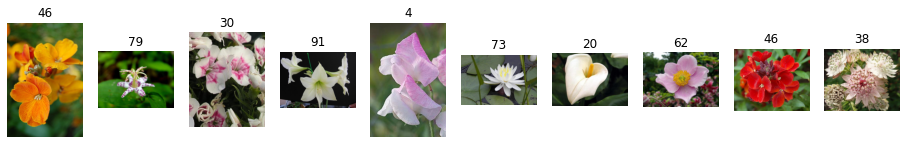

In [13]:
plot_samples(train_dataset, num_samples=10)

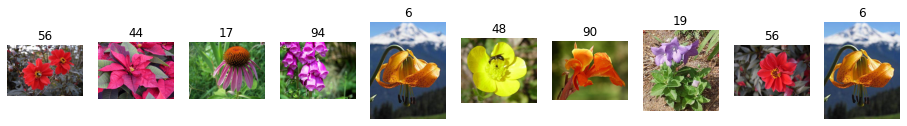

In [14]:
plot_samples(valid_dataset, num_samples=10)

In [15]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [16]:
NUM_WORKERS = 4 # or os.cpu_count()

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [17]:
class FlowersModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # используем предобученную модель ResNet-34
        self.net = models.resnet34(pretrained=True)
        # замораживаем веса
        for parameter in self.net.parameters():
            parameter.requres_grad = False
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = torch.nn.Linear(512, len(train_dataset.classes))

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch
        output = self(images)
        loss = loss = F.cross_entropy(output, target)
        top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-4)

In [18]:
model = FlowersModel()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [19]:
trainer = pl.Trainer(
    gpus=1, # amount of GPU we wanted to use
    max_epochs=30,
    progress_bar_refresh_rate=1,
)
trainer.fit(model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 21.3 M
--------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.348    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
torch.save(model.state_dict(), "model.pt")

In [21]:
model.to(device)

FlowersModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [22]:
from PIL import Image

test_path = '/content/flowerdata-module5/test/test'


class TestImageFolder:
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(self.root)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.root, self.image_files[idx])
        return self.transform(Image.open(image_file)), self.image_files[idx]

In [24]:
from torch.utils.data import DataLoader

test_dataset = TestImageFolder(test_path, transform=test_transformations)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [25]:
predictions = []
labels = []
with torch.no_grad():
    for images, lbls in tqdm(test_dataloader):
        probs = model(images.to(device))
        predictions.extend(probs.argmax(-1).tolist())
        labels.extend(lbls)

100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


In [27]:
idx_to_class = {i: c for c, i in dataset.class_to_idx.items()}

In [28]:
prediction_classes = []
for num in predictions:
    prediction_classes.append(int(idx_to_class[num]))

In [29]:
df = pd.DataFrame({
    'Id': labels,
    'Category': prediction_classes,
})
df.to_csv('submission.csv', index=False)
df.head(10)

,Id,Category
0,image_04352.jpg,36
1,image_01569.jpg,44
2,image_04940.jpg,20
3,image_06141.jpg,64
4,image_04720.jpg,55
5,image_06939.jpg,34
6,image_06769.jpg,1
7,image_00112.jpg,77
8,image_03654.jpg,53
9,image_00640.jpg,89
